<img src="IMG/logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales - Segundo Cuatrimestre 2025

# TS5: Estimación espectral: Ancho de banda de señales reales
#### Matías Cassino 

# Consignas

En el repositorio PDStestbench encontrará tres tipos de señales registradas:

- Electrocardiograma (ECG). En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas más abajo.

- Pletismografía (PPG). El archivo PPG.csv contiene una señal registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.

- Audio. Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.

Los detalles de cómo acceder a dichos registros los pueden encontrar en lectura_sigs.py

Se pide:

1) Realizar la estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

2) Realice una estimación del ancho de banda de cada señal y presente los resultados en un tabla para facilitar la comparación.

Bonus:

3) Proponga algún tipo de señal que no haya sido analizada y repita el análisis. No olvide explicar su origen y cómo fue digitalizada.


# Introducción
En este trabajo se analizan señales reales las cuales poseen SNR intrínseco, y, en consecuencia, esto implica que la energía nunca se anule debido al desparramo espectral. Entonces, para el estudio de la densidad espectral de potencia (PSD) se asume la hipótesis de que dentro de un ancho de banda se contiene un determinado porcentaje de la energía correspondiente a la potencia de la señal y con una mínima contribución por parte de la potencia de ruido, es decir, el SNR presenta un valor elevado y puede efectuarse una estimación ideónea.
Además, la estimación de la PSD depende de la resolución espectral y la varianza asociadas al método aplicado.

# Desarrollo experimental

In [1]:
#%% Modulos
import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt  
import scipy.io as sio
from scipy.io.wavfile import write
import matplotlib as mpl
import scipy.stats as st
import pandas as pd
#import sounddevice as sd

#%% Funciones
plt.close('all')

def ancho_de_banda(f,Px,porcentaje):
    pot_acum = np.cumsum(Px) #Potencia acumulada
    pot_acum_norm = pot_acum/pot_acum[-1] # Normalizo
    cond_aux=pot_acum_norm>=(porcentaje/100) # Máscara booleana
    f_umbral=f[cond_aux] # Filtro frecuencias según máscara 
    # idx = np.where(pot_acum_norm >= (porcentaje/100))[0] # Alternativa con índices que devuelve tupla y selecciono la primera en el vector de frecuencias
    f_wb=np.round(f_umbral[0]) # Tomo el primer valor redondeado
    print(f'El ancho de banda {f_wb} Hz contiene el {porcentaje}% de la potencia\n')
    return f_wb 

def welch(cant_promedio,vector,zp,fs,window):
    N=vector.shape[0] # N=Cantidad de muestras y accede al elemento 0
    nperseg=N//cant_promedio # L=largo del bloque
    print(f'El largo del bloque es: {nperseg}\n')
    nfft=zp*nperseg
    # Periodograma
    f_w, Px_w = sig.welch(vector, fs=fs, nperseg=nperseg, window=window, nfft=nfft)
    return f_w, Px_w

def plot_periodograma(f,Px,f_wb,title):
    # Periodograma
    plt.figure()
    plt.plot(f,Px)
    plt.axvline(f_wb, color='r', linestyle='--', label=f'BW ≈ {f_wb} Hz')
    plt.title(title)
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("PSD")
    plt.xlim([0,f_wb + 1])
    plt.grid()
    return

#%% Parámetros generales
windows=['blackmanharris','hann','hamming','flattop','boxcar']

##################
# Lectura de ECG sin ruido
##################
ecg_one_lead = np.load('Archivos_aux_TS5/ecg_sin_ruido.npy') # esto es N
# plt.figure()
# plt.plot(ecg_one_lead)

# Parámetros ECG
fs_ecg = 1000 # Hz
cant_promedio_ecg = 14 # K
zp_ecg=2

####################################
# Lectura de pletismografía (PPG) sin ruido
##################
ppg = np.load('Archivos_aux_TS5/ppg_sin_ruido.npy') # esto es N
# plt.figure()
# plt.plot(ppg)

# Parámetros PPG
fs_ppg = 400 # Hz
cant_promedio_ppg = 5 # K
zp_ppg=1

####################
# Lectura de audio cucaracha#
####################
# Cargar el archivo CSV como un array de NumPy
fs_cucaracha, wav_data_cucaracha = sio.wavfile.read('sonido/la cucaracha.wav')
# plt.figure()
# plt.plot(wav_data_cucaracha)

# Parámetros cucaracha
cant_promedio_cucaracha = 9 # K
zp_cucaracha=2

####################
# Lectura de audio prueba#
####################
# Cargar el archivo CSV como un array de NumPy
fs_prueba, wav_data_prueba = sio.wavfile.read('sonido/prueba psd.wav')
# plt.figure()
# plt.plot(wav_data_prueba)

# Parámetros prueba
cant_promedio_prueba = 12 # K 
zp_prueba=1

####################
# Lectura de audio silbido#
####################
# Cargar el archivo CSV como un array de NumPy
fs_silbido, wav_data_silbido = sio.wavfile.read('sonido/silbido.wav')
# plt.figure()
# plt.plot(wav_data_silbido)

# Parámetros silbido
cant_promedio_silbido = 25 # K 
zp_silbido=3

####################
# Lectura de audio bonus#
####################
fs_audio, wav_data_audio = sio.wavfile.read('sonido/knock.wav')
# sd.play(wav_data_audio, fs_audio)
if wav_data_audio.ndim > 1:
#     # promedio de canales (podés usar sum/2 o canal específico)
    wav_data_audio = wav_data_audio.mean(axis=1)
#plt.figure()
#plt.plot(wav_data_audio)

# Parámetros bonus
cant_promedio_audio = 15 # K
zp_audio=2


# Análisis de resultados

1) Se emplea el método de Welch a fin de estimar la PSD ponderando un ancho de banda que contenga el 99% de la potencia asociada a la señal. También, se ajustaron los parámetros de zero padding y cantidad de promedios para lograr una mejora artificial de la resolución espectral, y establecer una adecuada relación de compromiso entre la resolución espectral y la varianza respectivamente. En adición, se utilizó como ventana Blackman-Harris.

In [2]:
#%% Invocación de las funciones del punto 1 y Bonus
f_w_ecg, Px_w_ecg=welch(cant_promedio=cant_promedio_ecg,vector=ecg_one_lead,zp=zp_ecg,fs=fs_ecg,window=windows[1])
f_wb_ecg=ancho_de_banda(f_w_ecg,Px_w_ecg,porcentaje=99)

f_w_ppg, Px_w_ppg=welch(cant_promedio=cant_promedio_ppg,vector=ppg,zp=zp_ppg,fs=fs_ppg,window=windows[1])
f_wb_ppg=ancho_de_banda(f_w_ppg,Px_w_ppg,porcentaje=99)

f_w_cucaracha, Px_w_cucaracha=welch(cant_promedio=cant_promedio_cucaracha,vector=wav_data_cucaracha,zp=zp_cucaracha,fs=fs_cucaracha,window=windows[1])
f_wb_cucaracha=ancho_de_banda(f_w_cucaracha,Px_w_cucaracha,porcentaje=99)

f_w_prueba, Px_w_prueba=welch(cant_promedio=cant_promedio_prueba,vector=wav_data_prueba,zp=zp_prueba,fs=fs_prueba,window=windows[1])
f_wb_prueba=ancho_de_banda(f_w_prueba,Px_w_prueba,porcentaje=99)

f_w_silbido, Px_w_silbido=welch(cant_promedio=cant_promedio_silbido,vector=wav_data_silbido,zp=zp_silbido,fs=fs_silbido,window=windows[1])
f_wb_silbido=ancho_de_banda(f_w_silbido,Px_w_silbido,porcentaje=99)

f_w_audio, Px_w_audio=welch(cant_promedio=cant_promedio_audio,vector=wav_data_audio,zp=zp_audio,fs=fs_audio,window=windows[1])
f_wb_audio=ancho_de_banda(f_w_audio,Px_w_audio,porcentaje=99)

El largo del bloque es: 2142

El ancho de banda 31.0 Hz contiene el 99% de la potencia

El largo del bloque es: 8983

El ancho de banda 5.0 Hz contiene el 99% de la potencia

El largo del bloque es: 16000

El ancho de banda 2018.0 Hz contiene el 99% de la potencia

El largo del bloque es: 12000

El ancho de banda 2612.0 Hz contiene el 99% de la potencia

El largo del bloque es: 5760

El ancho de banda 6647.0 Hz contiene el 99% de la potencia

El largo del bloque es: 2321

El ancho de banda 3287.0 Hz contiene el 99% de la potencia



2)  Se exhibe gráficamente la estimación de la PSD junto con una cota asociada a la frecuencia del ancho de banda que delimita el porcentaje de energía comprendida para cada señal sin, o con exigua, incidencia de la potencia de ruido.

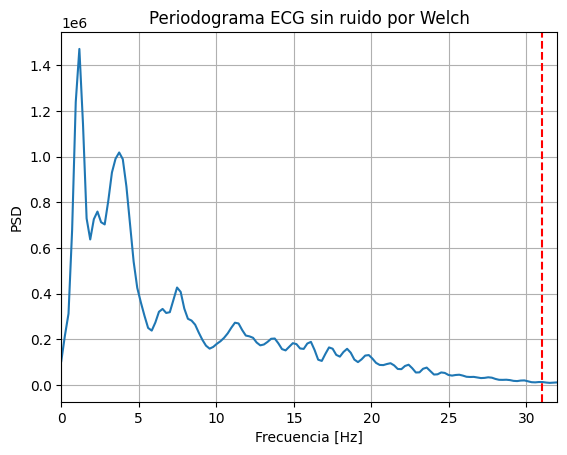

In [3]:
#%% Invocación de las funciones del punto 2 y Bonus
plot_periodograma(f_w_ecg, Px_w_ecg, f_wb_ecg, title="Periodograma ECG sin ruido por Welch")

- Se observa energía entre 0.5-33Hz aproximadamente, lo cual se vincula con la ondas del complejo QRS a través de los máximos y mínimos.

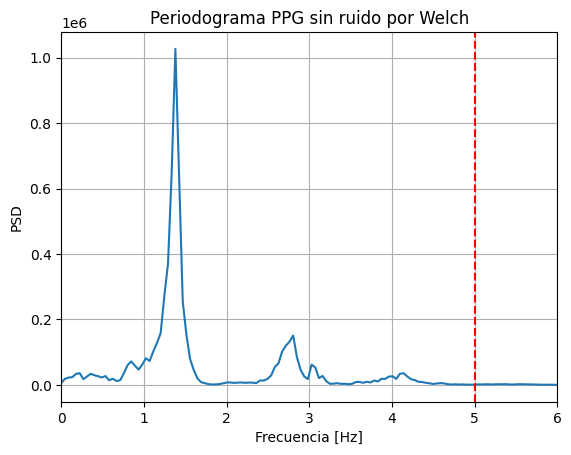

In [4]:
#%% Invocación de las funciones del punto 2 y Bonus
plot_periodograma(f_w_ppg, Px_w_ppg, f_wb_ppg, title="Periodograma PPG sin ruido por Welch")

- Se evidencia una concentración de energía en bajas frecuencias, específicamente menores a 5 Hz. A su vez, posee un máximo alrededor de 1Hz, el cual se asocia a la frecuencia cardíaca fundamental según el cambio de volumen de sangre en los vasos sanguíneos.

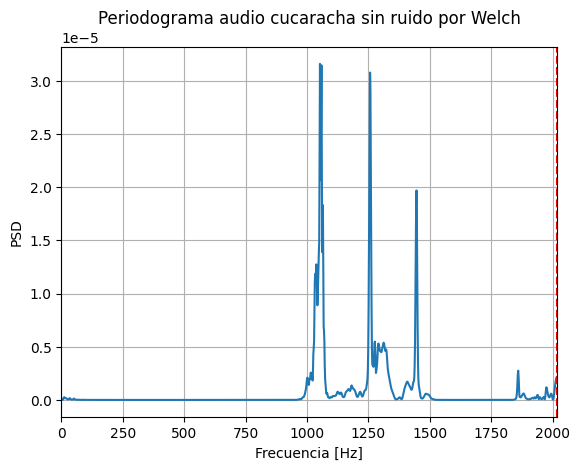

In [5]:
#%% Invocación de las funciones del punto 2 y Bonus
plot_periodograma(f_w_cucaracha, Px_w_cucaracha, f_wb_cucaracha, title="Periodograma audio cucaracha sin ruido por Welch")

- Se exponen los tres máximos correspondientes a los principales tonos de la melodía.

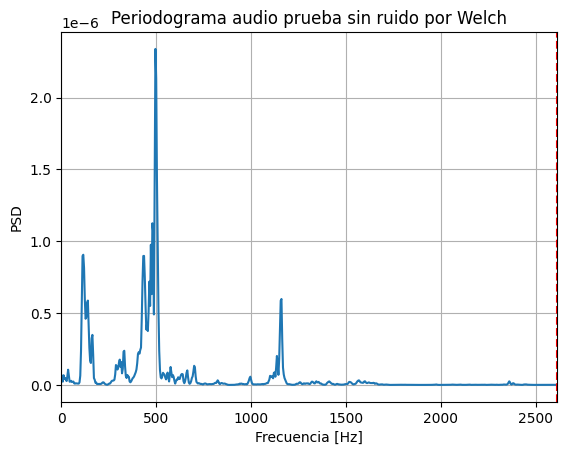

In [6]:
#%% Invocación de las funciones del punto 2 y Bonus
plot_periodograma(f_w_prueba, Px_w_prueba, f_wb_prueba, title="Periodograma audio prueba sin ruido por Welch")

-  Se observa un amplio complejo armónico en conjunto a los picos de resonancia intrínsecos de la voz.

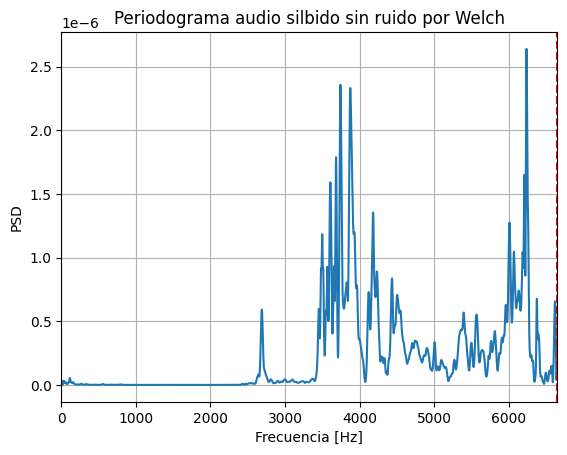

In [7]:
#%% Invocación de las funciones del punto 2 y Bonus
plot_periodograma(f_w_silbido, Px_w_silbido, f_wb_silbido, title="Periodograma audio silbido sin ruido por Welch")

- Se identifica mayor potencia en las frecuencias donde el silbido es más agudas.

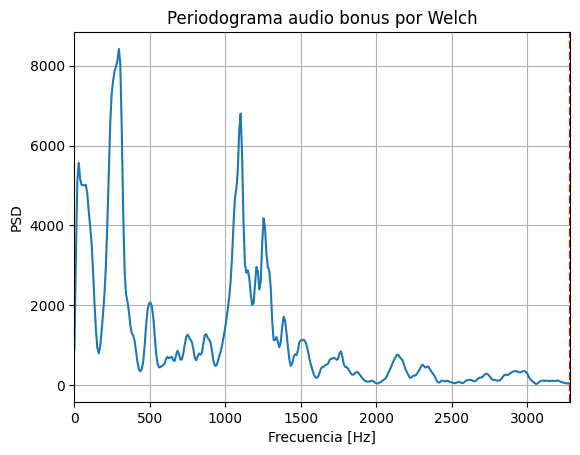

In [8]:
#%% Invocación de las funciones del punto 2 y Bonus
plot_periodograma(f_w_audio, Px_w_audio, f_wb_audio, title="Periodograma audio bonus por Welch")

- Se constata la mayor concentración de potencia para las frecuencias en las cuales se escuchan los golpes.

In [9]:
#%% Invocación de las funciones del punto 2 y Bonus
tabla_bw = pd.DataFrame({
    'Archivo de Señal': [
        'ECG sin ruido',
        'PPG sin ruido',
        'Audio - La Cucaracha',
        'Audio - Prueba PSD',
        'Audio - Silbido',
        'Audio - Bonus'
    ],
    'Ancho de Banda [Hz]': [
        f_wb_ecg,
        f_wb_ppg,
        f_wb_cucaracha,
        f_wb_prueba,
        f_wb_silbido,
        f_wb_audio
    ]
}) # Tabla de 2 columnas (etiquetas) y 6 filas (listas)

print("\n=== Tabla comparativa de anchos de banda ===\n")
print(tabla_bw.to_string(index=False))


=== Tabla comparativa de anchos de banda ===

    Archivo de Señal  Ancho de Banda [Hz]
       ECG sin ruido                 31.0
       PPG sin ruido                  5.0
Audio - La Cucaracha               2018.0
  Audio - Prueba PSD               2612.0
     Audio - Silbido               6647.0
       Audio - Bonus               3287.0


# Conclusiones

Finalmente, deduce que las señales biológicas poseen mayor energía concentrada a bajas frecuencias, mientras que las acústicas comprenden espectros con mayor ancho de banda y menor amplitud. Esta dependencia se debe al vínculo entre el dominio temporal y espectral.

# Autoevaluación
A) Sí, resolví la tarea con seguridad.

B) Lo aprendido en esta tarea fueron las técnicas de estimación de la densidad espectral de potencia para un determinado ancho de banda a partir del porcentaje de potencia contenido.

C) Sí, se empleó chat GPT para codificar la tabla de punto 2.